In [1]:
import numpy as np
import pandas as pd
import emcee
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Leitura dos dados
# =========================

# Cronômetros Cósmicos
df_cc = pd.read_csv("/home/brunowesley/projetos/MCMC-cosmo/Data/CC/CC_Hz_data.txt", sep=r"\s+")
z_cc   = df_cc["z_cc"].to_numpy(float)
H_obs  = df_cc["H_cc"].to_numpy(float)
H_err   = df_cc["H_cc_err"].to_numpy(float)

In [3]:
# ===================
# Fiducial
# ===================

# Priors uniformes
H0_min, H0_max = 50., 90.
Om0_min, Om0_max = 0.1, 0.6
w_min, w_max = -3.0, 1.0

# Parâmetros cosmológicos
Or0 = 7.881e-5

In [4]:
# =========================
# Funções de Hubble
# =========================

def E_wCDM(z, Om0, w):
    Om = Om0 * (1 + z)**3
    Or = Or0 * (1 + z)**4
    Ode0 = 1 - Om0 - Or0
    Ode = Ode0 * (1 + z)**(3*(1 + w))
    return np.sqrt(Om + Or + Ode)

def H_wCDM(z, H0, Om0, w):
    return H0 * E_wCDM(z, Om0, w)


print(H_wCDM(z_cc, 70, 0.3, -1))

[ 72.32519084  73.03322237  74.13140789  76.0572717   76.41650182
  77.22840679  77.26949328  80.26046     80.70603376  84.04613993
  85.41639738  86.39894292  86.41896471  87.64799257  88.93827747
  90.00503237  90.44606006  90.53673759  96.82220132 101.99455412
 106.35561538 106.35561538 108.34165931 109.57512345 114.56146009
 114.90041639 116.26425256 125.94082596 142.85712011 146.03393586
 151.12077894 156.63962462 165.0788386  184.45353244 204.39288851]


In [5]:
# =========================================
# Likelihood CC
# =========================================

# Priors
def lnprior_cc(theta_cc):
    H0, Om0, w = theta_cc
    if not (H0_min <= H0 <= H0_max): return -np.inf
    if not (Om0_min <= Om0 <= Om0_max): return -np.inf
    if not (w_min <= w <= w_max): return -np.inf
    return 0.0


# Likelihood
def lnlike_cc(theta_cc, z_cc, H_obs, H_err):
    H0, Om0, w = theta_cc
    H_theo = H_wCDM(z_cc, H0, Om0, w)
    chi2_cc = np.sum(((H_obs - H_theo) / H_err)**2) 
    return -0.5 * chi2_cc


# Posteriori
def lnprob_cc(theta_cc, z_cc, H_obs, H_err):
    lp = lnprior_cc(theta_cc)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_cc(theta_cc, z_cc, H_obs, H_err)

# Teste rápido
print(lnprob_cc([70., 0.3, -1.0], z_cc, H_obs, H_err))

-7.567754449795606


In [ ]:
# =========================
# MCMC
# =========================

ndim, nwalkers, nsteps, nburn = 3, 35, 45500, 3500
rng = np.random.default_rng(42)

p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min, H0_max, size=nwalkers)           # H0 uniforme
p0[:,1] = rng.uniform(Om0_min, Om0_max, size=nwalkers)         # Omega_m0 uniforme
p0[:,2] = rng.uniform(w_min, w_max, size=nwalkers)         # w uniforme

# with multiprocessing.Pool() as pool:
#     sampler = emcee.EnsembleSampler(
#         nwalkers, ndim, lnprob_cc, pool=pool
#     )
#     sampler.run_mcmc(p0, nsteps, progress=True)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_cc, args=(z_cc, H_obs, H_err))
sampler.run_mcmc(p0, nsteps, progress=True)


# Pegando amostras após burn-in
flat_samples = sampler.get_chain(discard=nburn, flat=True)

# Cadeia completa: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
np.save("chain_wCDM_cc.npy", chain)

# Cadeia "achatada" (flat) após burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_wCDM_cc.npy", flat_samples)

100%|██████████| 45500/45500 [00:23<00:00, 1907.58it/s]


Removed no burn in


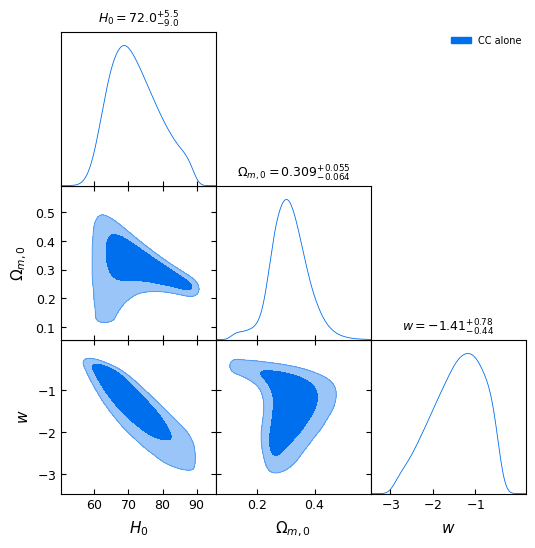

In [ ]:
# =========================
# GetDist
# =========================

param_names  = ["H0", "Omega_m0", "w"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"w"]

samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})

# samples.setRanges({
#     "H0": (50, 90),
#     "Omega_m": (0.1, 0.6)
# })

g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3

# Triangle plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["CC alone"],
    #contour_colors=["#"],
    title_limit=1
)

plt.savefig("triangle_wCDM_cc.png", dpi=300, bbox_inches="tight")
plt.show()